# Import libs

In [16]:
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt  # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm


In [17]:
print("System Version:", sys.version)
print("PyTorch version", torch.__version__)
print("Torchvision version", torchvision.__version__)
print("Numpy version", np.__version__)
print("Pandas version", pd.__version__)


System Version: 3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)]
PyTorch version 2.1.2+cpu
Torchvision version 0.16.2+cpu
Numpy version 1.26.3
Pandas version 2.1.4


# Download dataset with Kaggle API

You need an API key to use the Kaggle API.  
Click on your profile picture (top right), go to Settings, Create New Token, then download & open the file.  
Copy the contents, and paste them in the following cell (e.g., creds = '{"username":"xxx","key":"xxx"}'):

In [6]:
# creds = '{"username":"YOUR_USERNAME","key":"YOUR_API_KEY"}'

Then execute this cell (this only needs to be run once) - thanks [Jeremy Howard](https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners)!

In [7]:
# for working with paths in Python, I recommend using `pathlib.Path`

# cred_path = Path("~/.kaggle/kaggle.json").expanduser()
# if not cred_path.exists():
#     cred_path.parent.mkdir(exist_ok=True)
#     cred_path.write_text(creds)
#     cred_path.chmod(0o600)




Run this next cell to download the dataset from Kaggle:


In [9]:
# !kaggle datasets download -d gpiosenka/cards-image-datasetclassification


  0%|          | 0.00/385M [00:00<?, ?B/s]
  0%|          | 1.00M/385M [00:00<06:03, 1.11MB/s]
  1%|          | 2.00M/385M [00:01<03:05, 2.17MB/s]
  1%|          | 4.00M/385M [00:01<01:27, 4.56MB/s]
  2%|▏         | 7.00M/385M [00:01<00:46, 8.58MB/s]
  2%|▏         | 9.00M/385M [00:01<00:36, 10.8MB/s]
  3%|▎         | 12.0M/385M [00:01<00:27, 14.0MB/s]
  4%|▎         | 14.0M/385M [00:01<00:31, 12.2MB/s]
  4%|▍         | 17.0M/385M [00:02<00:27, 14.2MB/s]
  5%|▌         | 20.0M/385M [00:02<00:27, 13.9MB/s]
  6%|▌         | 22.0M/385M [00:02<00:26, 14.2MB/s]
  7%|▋         | 26.0M/385M [00:02<00:22, 17.0MB/s]
  7%|▋         | 28.0M/385M [00:02<00:24, 15.2MB/s]
  8%|▊         | 30.0M/385M [00:02<00:26, 14.1MB/s]
  8%|▊         | 32.0M/385M [00:03<00:25, 14.3MB/s]
  9%|▉         | 35.0M/385M [00:03<00:23, 15.6MB/s]
 10%|▉         | 37.0M/385M [00:03<00:24, 14.8MB/s]
 11%|█         | 41.0M/385M [00:03<00:20, 18.0MB/s]
 11%|█         | 43.0M/385M [00:03<00:20, 17.9MB/s]
 12%|█▏        | 45.

The API command above can be obtained by clicking the three black dots and selecting `Copy API command`:   
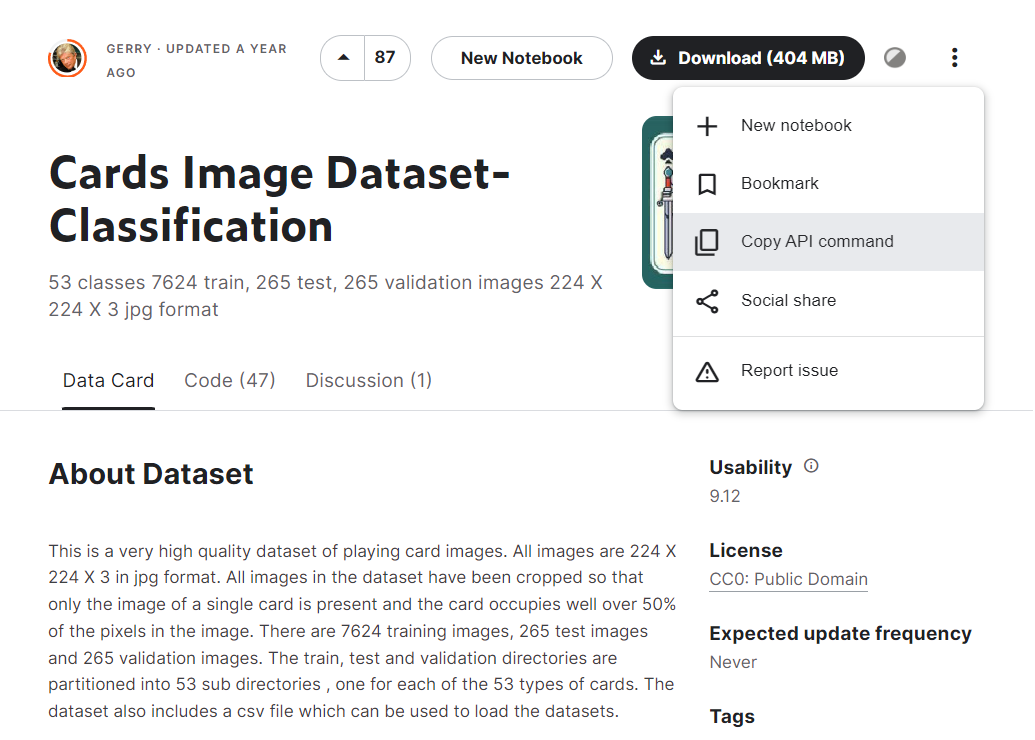

# Step 1. Pytorch Dataset (and Dataloader)

Create a custom dataset class that inherits from PyTorch's Dataset class:

In [20]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

    @property
    def classes(self):
        return self.data.classes


## Transforming training dataset

In [22]:
dataset = PlayingCardDataset(data_dir="./input/train/")

6


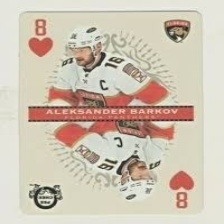

In [49]:
image, label = dataset[999]
print(label)
image


Get a dictionary associating target values with folder names:


In [40]:
data_dir = "./input/train/"
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)


{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [50]:
transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ]
)

dataset = PlayingCardDataset(data_dir, transform)


Recreate the dataset with `transform`:

In [55]:
image, label = dataset[999]
print(label)
image.shape


6


torch.Size([3, 128, 128])

This next loop doesn't execute any specific functions or operations on the dataset elements. Its primary purpose is to check that the dataset is iterable, meaning it can be looped over without causing errors.   

This kind of loop is useful for quickly verifying that the dataset setup is correct, particularly that the __getitem__ method of the PlayingCardDataset class is functioning as intended. It's a simple test to ensure that at least the first item can be accessed and that the dataset behaves as expected in a loop structure.

In [56]:
# iterate over dataset
for image, label in dataset:
    break


## Dataloaders

In PyTorch, DataLoaders are used for efficiently loading and iterating over datasets. They handle the process of fetching data, potentially in parallel, and preparing it for training or inference in neural networks.  

DataLoaders are particularly useful for managing large datasets that cannot be loaded entirely into memory, offering functionality like batching, shuffling, and data transformation. They streamline the data pipeline, ensuring that data is readily available in the required format for each training step without manual handling, thus optimizing the computational efficiency of the model training process.

In [57]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [58]:
for images, labels in dataloader:
    break


`images.shape` now gives an additional dimension (32) - reflecting `batch_size`

In [59]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

labels are also now not in order, because the arg `shuffle=True` was provided.

In [60]:
labels

tensor([12, 19, 48, 38, 15, 14, 31, 39,  7, 52,  9, 21, 49, 28, 18, 17, 14, 36,
        16, 16, 17, 37, 33, 40, 51, 24, 48, 29, 29,  9, 12, 37])

# Step 2: PyTorch Model